In [1]:
!pip install neuralforecast

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 MB 17.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.6 MB

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Импорт данных

In [76]:
df = pd.read_csv('./данные для исследований/Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия — Диаграмма.csv', sep=';')

Для библиотеки необходимо определнно назвать столбцы

In [77]:
# Меняем названия столбцов
df.columns = ['unique_id', 'ds', 'y']

# Меняем формат даты
df.ds = pd.to_datetime(df.ds, format='%d.%m.%Y')

# 1. Тестируем GRU, Трансформера и NHITS

на Индикаторе бизнес климата ЦБ

In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MSE
from neuralforecast.models import GRU, NHITS, VanillaTransformer

In [78]:
horizon = 6     # прогноз на 6 месяцев
lookback = 12   # длина входных данных
maxsteps = 100
learning_rate = 0.001

In [79]:
df_train = df.iloc[:-6]   # 262 Значений
df_test = df.iloc[-6:]    # 6 значений

In [175]:
models = [
    NHITS(
        h=horizon,
        input_size=lookback,
        max_steps=maxsteps,
        scaler_type='standard',
        loss=MSE(),
        learning_rate=learning_rate
    ),
    # Трансформер
    VanillaTransformer(
        h=horizon,
        input_size=lookback,
        hidden_size=8,
        conv_hidden_size=16,
        n_head=2,
        loss=MSE(),
        scaler_type='robust',
        learning_rate=0.001,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2
    )
]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=df_train, val_size=12)

Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [144]:
predicts = nf.predict(df.iloc[:-horizon]).reset_index()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [145]:
predicts

,unique_id,ds,NHITS,VanillaTransformer
0,62291,2023-11-30,5.527455,3.417118
1,62291,2023-12-31,6.891848,7.236289
2,62291,2024-01-31,5.333371,9.612972
3,62291,2024-02-29,9.404997,14.055609
4,62291,2024-03-31,10.639128,14.195814
5,62291,2024-04-30,7.690466,12.524661


In [126]:
Y_hat_insample = nf.predict_insample(step_size=horizon).reset_index()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [127]:
Y_hat_insample.head(3)

,unique_id,ds,cutoff,NHITS,VanillaTransformer,y
0,62291,2002-05-31,2002-04-30,-0.037443,0.157147,6.112399
1,62291,2002-06-30,2002-04-30,-0.021837,-0.150273,11.830618
2,62291,2002-07-31,2002-04-30,0.107336,0.046832,16.781130


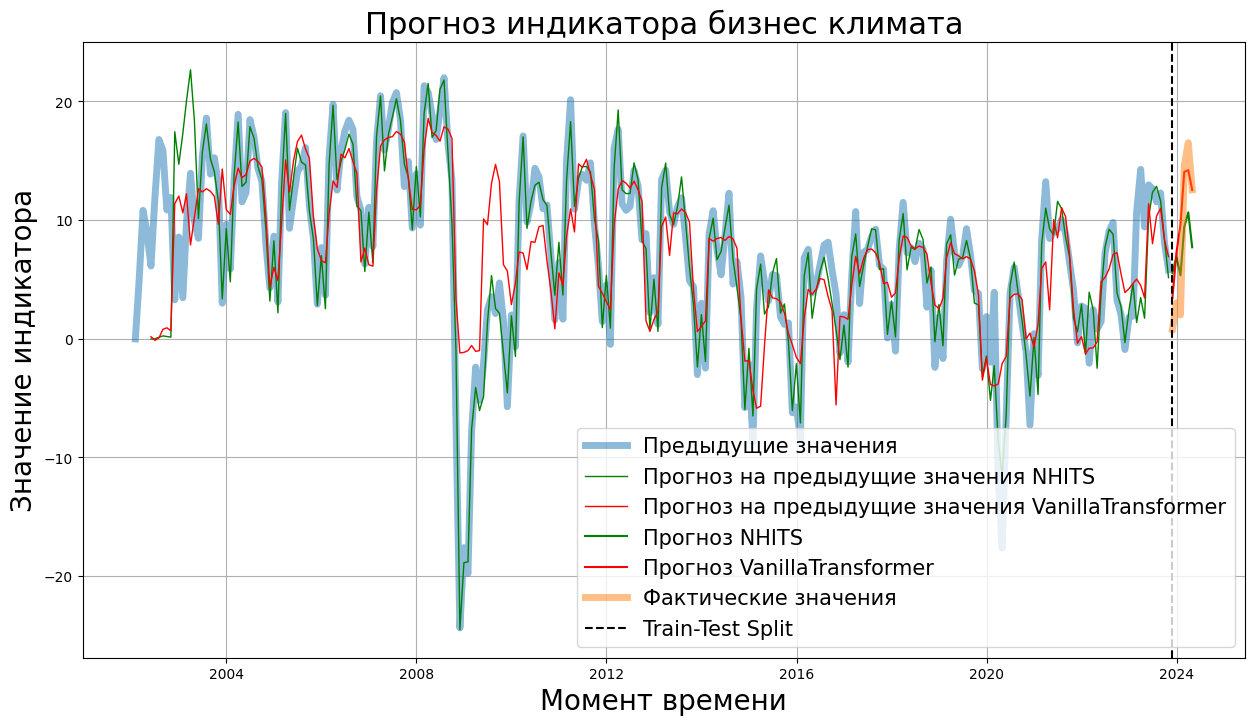

In [137]:
fig, ax = plt.subplots(figsize = (15, 8))

ax.plot(df_train.ds, df_train.y, label='Предыдущие значения', linewidth=5, alpha=0.5)
ax.plot(Y_hat_insample.ds, Y_hat_insample.NHITS, label='Прогноз на предыдущие значения NHITS', linewidth=1, color='green')
ax.plot(Y_hat_insample.ds, Y_hat_insample.VanillaTransformer, label='Прогноз на предыдущие значения VanillaTransformer', linewidth=1, color='red')

ax.plot(predicts.ds, predicts.NHITS, label='Прогноз NHITS', color='green')
ax.plot(predicts.ds, predicts.VanillaTransformer, label='Прогноз VanillaTransformer', color='red')
ax.plot(df.ds.iloc[-horizon:], df.y.iloc[-horizon:], label='Фактические значения', linewidth=5, alpha=0.5)

plt.axvline(df.ds.iloc[-6], color='black', linestyle='--', label='Train-Test Split')

ax.set_title('Прогноз индикатора бизнес климата', fontsize=22)
ax.set_ylabel('Значение индикатора', fontsize=20)
ax.set_xlabel('Момент времени', fontsize=20)

ax.legend(prop={'size': 15})
ax.grid()

# Качество моделей

In [129]:
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

### Обучающая выборка

In [130]:
evaluation_df = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'], metrics=[rmse, mape])
evaluation_df

,unique_id,metric,NHITS,VanillaTransformer
0,62291,rmse,3.091479,4.913715
1,62291,mape,0.376637,1.087776


### Тестовая выборка

In [146]:
evaluation_df_test = evaluate(predicts.merge(df_test), metrics=[rmse, mape])
evaluation_df_test

,unique_id,metric,NHITS,VanillaTransformer
0,62291,rmse,4.716740,3.842951
1,62291,mape,1.699902,1.470627


скорее всего NHITS переобучилась

# 2 Тестируем на других индексах

In [29]:
from datetime import date

In [160]:
date_start = date(year=2015, month=1, day=1)

def data_prerpocess(df):
    """Приводим дату к нужнмоу формату, удаляем лишние столбцы, сортируем по дате, оставим только от 2015 года"""
    
    df.date = pd.to_datetime(df.date, format='%d.%m.%Y')

    df.columns = ['unique_id', 'ds', 'y']
    
    return df

In [161]:
path = './данные для исследований/'

indexes = {
    'Новостной индекс ЦБ': pd.read_csv(path + 'Новостной идекс ЦБ, Россия — Диаграмма.csv', sep=';'),
    'Спрос на промышленность': pd.read_csv(path + 'Оценка изменения спроса на продукцию, товары, услуги (промышленность), пункты, Россия — Диаграмма.csv', sep=';'),
    'ИПЦ': pd.read_csv(path + 'Индекс потребительских цен, Россия — Диаграмма.csv', sep=';'),
    'ИПП': pd.read_csv(path + 'Индекс промышленного производства, Россия — Диаграмма.csv', sep=';'),
    'Оборот розничной торговли': pd.read_csv(path + 'Оборот розничной торговли, Россия — Диаграмма.csv', sep=';'),
    'Погрузка на сети РЖД': pd.read_csv(path + 'Погрузка на сети РЖД, млн тонн, Россия — Диаграмма.csv', sep=';')
}

indexes = {index: data_prerpocess(df) for index, df in indexes.items()}

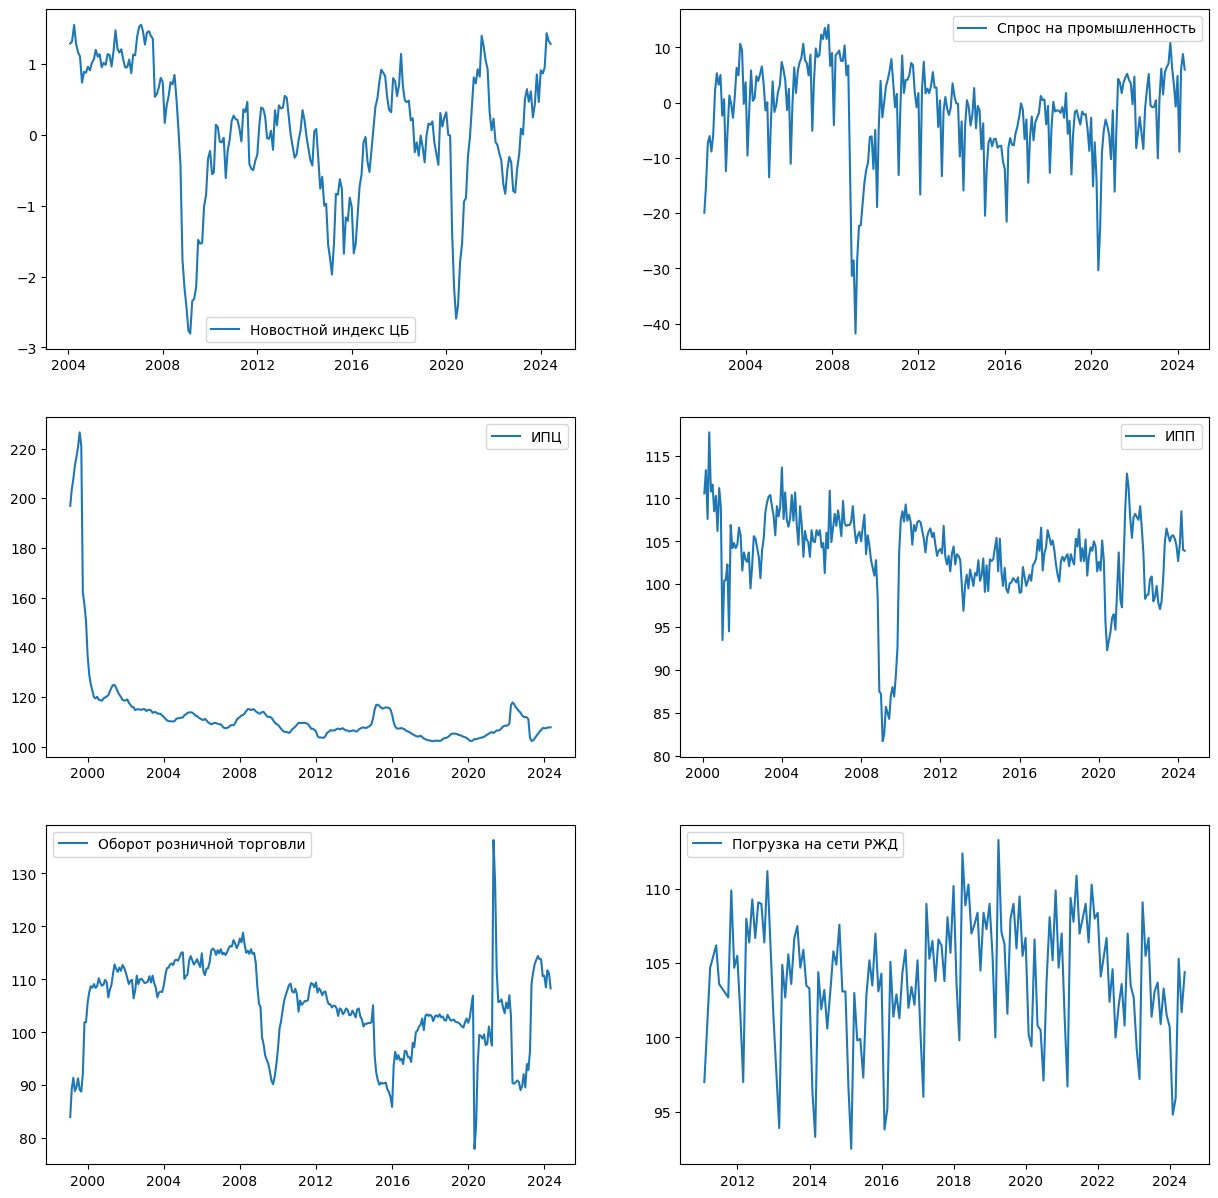

In [162]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1
                
        axes[i][j].plot(data.ds, data.y, label=label)
        axes[i][j].legend()


# 3. Создание моделей

In [163]:
models = [
    NHITS(
        h=horizon,
        input_size=lookback,
        max_steps=maxsteps,
        # scaler встроен в модель, поэтому не надо предобрабатывать
        scaler_type='standard',
        loss=MSE(),
        learning_rate=learning_rate
    ),
    VanillaTransformer(
        h=horizon,
        input_size=lookback,
        loss=MSE(),
        learning_rate=learning_rate,
        scaler_type='robust',
        hidden_size=8,
        conv_hidden_size=16,
        n_head=2,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2
    )
]

Seed set to 1
Seed set to 1


In [164]:
index_models = dict()

In [165]:
for index, df in indexes.items():
    # обучать будем по всем значениям до длины прогноза
    df_train = df.iloc[:-horizon]
    
    nf = NeuralForecast(models=models, freq='M')
    nf.fit(df=df_train, val_size=12)

    # сохраняем модель
    index_models[index] = nf

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [170]:
results = dict()

for label, df in indexes.items():
        df_train = df.iloc[:-6]
        model = index_models[label]
        
        # Прогноз на предыдущее значение
        Y_hat_insample = model.predict_insample(step_size=horizon).reset_index()
        
        # Прогноз на будущее
        predicts = model.predict(df_train).reset_index()

        results[label] = Y_hat_insample, predicts

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


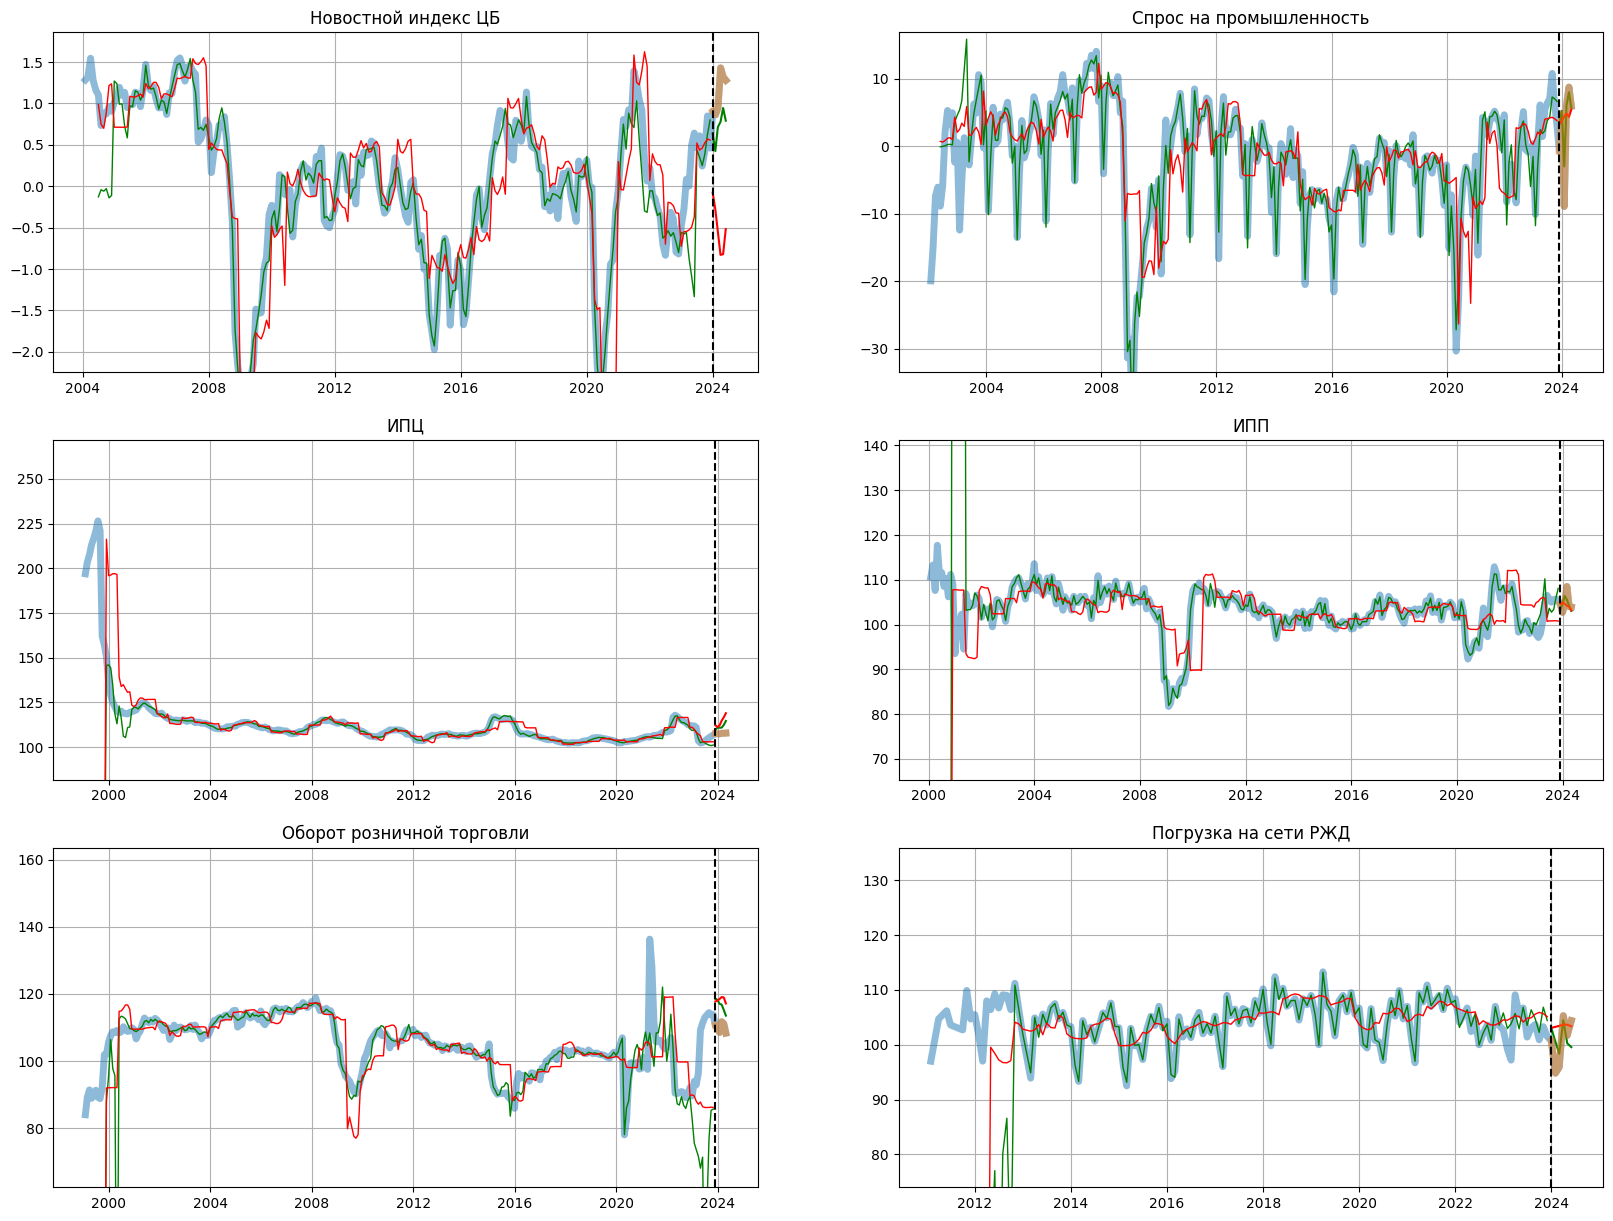

In [179]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

k = 0
for i in range(3):
    for j in range(2):
        label, df = list(indexes.items())[k]
        k += 1

        Y_hat_insample, predicts = results[label]

        ymax, ymin = df.y.max(), df.y.min()

        axes[i][j].plot(df.ds, df.y, label='Предыдущие значения', linewidth=5, alpha=0.5)
        axes[i][j].plot(Y_hat_insample.ds, Y_hat_insample.NHITS, label='Прогноз на предыдущие значения NHITS', linewidth=1, color='green')
        axes[i][j].plot(Y_hat_insample.ds, Y_hat_insample.VanillaTransformer, label='Прогноз на предыдущие значения VanillaTransformer', linewidth=1, color='red')
        
        axes[i][j].plot(predicts.ds, predicts.NHITS, label='Прогноз NHITS', color='green')
        axes[i][j].plot(predicts.ds, predicts.VanillaTransformer, label='Прогноз VanillaTransformer', color='red')
        axes[i][j].plot(df.ds.iloc[-horizon:], df.y.iloc[-horizon:], label='Фактические значения', linewidth=5, alpha=0.5)
        
        axes[i][j].axvline(df.ds.iloc[-6], color='black', linestyle='--', label='Train-Test Split')
        
        axes[i][j].set_title(label)

        axes[i][j].set_ylim([0.8 * ymin, 1.2 * ymax])

        # красный - трансформер, зеленый - NHiTS
        # axes[i][j].legend()
        axes[i][j].grid()

# Качество моделей

### Новостной индекс ЦБ

In [180]:
evaluation_df = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'], metrics=[rmse, mape])
evaluation_df

,unique_id,metric,NHITS,VanillaTransformer
0,62290,rmse,23.218801,21.571203
1,62290,mape,0.061914,0.069349


In [181]:
evaluation_df_test = evaluate(predicts.merge(df_test), metrics=[rmse, mape])
evaluation_df_test

,unique_id,metric,NHITS,VanillaTransformer


In [191]:
for index, df in indexes.items():
    print(df.unique_id.unique(), index)

[62293] Новостной индекс ЦБ
[62292] Спрос на промышленность
[62434] ИПЦ
[62298] ИПП
[62414] Оборот розничной торговли
[62290] Погрузка на сети РЖД


In [207]:
for index, df in indexes.items():
    df_test = df.iloc[-7:-1]
    Y_hat_insample, predicts = results[index]
    
    evaluation_df = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'], metrics=[rmse, mape])

    print(f'\n---{index}---')
    print(
        f'''NHITS:
        - rmse = {evaluation_df.NHITS.iloc[0]}
        - mape = {evaluation_df.NHITS.iloc[1]}
          '''
    )
    print(
        f'''VanillaTransformer:
        - rmse = {evaluation_df.VanillaTransformer.iloc[0]}
        - mape = {evaluation_df.VanillaTransformer.iloc[1]}
          '''
    )
    


---Новостной индекс ЦБ---
NHITS:
        - rmse = 0.2908560335636139
        - mape = 3.865849494934082
          
VanillaTransformer:
        - rmse = 0.5367010831832886
        - mape = 3.981510877609253
          

---Спрос на промышленность---
NHITS:
        - rmse = 2.4146344661712646
        - mape = 0.9263496398925781
          
VanillaTransformer:
        - rmse = 6.728930473327637
        - mape = 1.883945345878601
          

---ИПЦ---
NHITS:
        - rmse = 29.10995101928711
        - mape = 0.028069866821169853
          
VanillaTransformer:
        - rmse = 31.281091690063477
        - mape = 0.046718280762434006
          

---ИПП---
NHITS:
        - rmse = 32.35324478149414
        - mape = 0.06835848093032837
          
VanillaTransformer:
        - rmse = 16.562664031982422
        - mape = 0.05430734157562256
          

---Оборот розничной торговли---
NHITS:
        - rmse = 16.931419372558594
        - mape = 0.05117262154817581
          
VanillaTransformer:
    